In [1]:
!pip install -q --upgrade flax optax rdkit tokenizers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.30.2 requires tokenizers!=0.11.3,<0.14,>=0.11.1, but you have tokenizers 0.15.2 which is incompatible.


In [1]:
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import struct
import optax
from jax_tqdm import scan_tqdm

# imoprt models from models.py
from models import Transformer, Encoder, TransformerConfig

# Viz
import matplotlib.pyplot as plt

# for use with loading and manipulating SMILES strings
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# for preprocessor training/tokenizing data
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

# Training a Tokenizer on QM9 Smiles Strings.

In [76]:
def load_data(name):
    data = pd.read_csv(name)
    return data.pop("smiles"), data

In [9]:
def to_jax(tokenized):
    tokens = [np.array(t.ids, dtype=np.uint8) for t in tokenized]
    attn = [np.array(t.attention_mask, dtype=np.uint8) for t in tokenized]
    return jnp.array(tokens), jnp.array(attn)

In [77]:
x, y = load_data("train.csv")

In [78]:
y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,5.7535,60.31,-7.744360,-0.533343,7.211017,936.5708,2.289239,-10167.250,-10167.063,-10167.0370,-10168.1330,23.859,-52.135574,-52.410984,-52.693630,-48.638912,6.65469,1.38396,1.16899
1,0.1699,64.91,-7.221901,-0.236739,6.985163,932.4480,2.632130,-9730.933,-9730.745,-9730.7200,-9731.8110,24.573,-57.644634,-57.957237,-58.265625,-53.866226,5.66266,1.36661,1.30817
2,2.6169,60.84,-7.902186,-0.838111,7.064076,917.6343,2.303145,-10167.362,-10167.178,-10167.1520,-10168.2330,23.607,-52.247580,-52.525654,-52.808296,-48.739000,6.03442,1.37003,1.28250
3,4.6448,57.04,-8.234165,-1.428598,6.802846,897.7255,1.952635,-10603.292,-10603.108,-10603.0820,-10604.1710,22.987,-46.350708,-46.591150,-46.848080,-43.127113,6.06217,1.35732,1.31225
4,2.8783,67.03,-6.364743,0.024490,6.389233,720.9435,3.004137,-9293.555,-9293.405,-9293.3790,-9294.3545,21.977,-62.091576,-62.482380,-62.816483,-57.958927,5.38993,2.16696,1.80977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110826,1.6637,69.37,-6.133446,1.600029,7.733476,760.7472,3.466894,-10901.803,-10901.659,-10901.6340,-10902.5980,23.658,-69.555380,-70.028700,-70.414180,-64.734830,3.59483,2.19899,1.90423
110827,1.2976,69.52,-6.511684,1.654452,8.168858,762.6354,3.469316,-10901.689,-10901.547,-10901.5205,-10902.4840,23.697,-69.442320,-69.915634,-70.301140,-64.621740,3.65648,2.14237,1.90439
110828,1.2480,73.60,-6.076302,1.959220,8.035522,780.3553,3.822057,-10360.842,-10360.697,-10360.6720,-10361.6370,23.972,-72.289990,-72.801025,-73.212240,-67.177280,3.67118,2.14314,1.89501
110829,1.9576,77.40,-5.774256,2.397323,8.171579,803.1904,4.142171,-9924.547,-9924.399,-9924.3740,-9925.3440,24.796,-77.821304,-78.368140,-78.805080,-72.433290,3.52845,2.15131,1.86582


In [4]:
x[3]

'[H]C#CC([H])([H])N1N=NN=N1'

QM9 only contains CHONF molecules, meaning we don't have to do fancy tokenization to keep letters of atoms together. We'll do BPE tokenization and set a minimum frequency of 1,000 to only capture motifs of molecule structure without over-memorizing the molecules. The choic of 1,000 was arbitrary and might need tuned down a little bit.

In [6]:
# Initialize a tokenizer
tokenizer = Tokenizer(BPE())

# Use whitespace pre-tokenizer

# Initialize a trainer with your desired settings
trainer = BpeTrainer(special_tokens=["[PAD]", "[CLS]", "[MASK]"], min_frequency=1_000, show_progress=True)

# Train your tokenizer on a list of files
tokenizer.train_from_iterator(x, trainer)
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]")

# Save the tokenizer for later use
tokenizer.save("./bpe.tokenizer.json")

In [7]:
for t in x[:5]:
    print(tokenizer.encode(t).ids)

[66, 31, 55, 184, 72, 114]
[66, 31, 55, 72, 30, 65, 55]
[66, 31, 55, 184, 65, 55]
[66, 31, 55, 184, 212]
[57, 34, 125, 21, 115, 10, 28, 33, 179]


In [20]:
for t in x[:5]:
    print(tokenizer.encode(t).tokens)

['[H]C#C', 'C([H])([H])', 'N1', 'N=N', 'N=', 'C1[H]']
['[H]C#C', 'C([H])([H])', 'N1', 'N=', 'C([H])', 'C([H])=', 'N1']
['[H]C#C', 'C([H])([H])', 'N1', 'N=N', 'C([H])=', 'N1']
['[H]C#C', 'C([H])([H])', 'N1', 'N=N', 'N=N1']
['[H]C1=', 'C2', 'N(', 'N', '[C+]', '1', '[H])', 'C1([H])', 'C([H])([H])C21[H]']


In [8]:
sample = tokenizer.encode_batch(x[:5])

In [23]:
sample

[Encoding(num_tokens=9, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=9, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=9, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=9, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=9, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [10]:
sample_ids, sample_masks = to_jax(sample)

2024-03-03 18:39:16.975301: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
sample_ids

Array([[ 66,  31,  55, 184,  72, 114,   0,   0,   0],
       [ 66,  31,  55,  72,  30,  65,  55,   0,   0],
       [ 66,  31,  55, 184,  65,  55,   0,   0,   0],
       [ 66,  31,  55, 184, 212,   0,   0,   0,   0],
       [ 57,  34, 125,  21, 115,  10,  28,  33, 179]], dtype=uint8)

In [12]:
sample_masks

Array([[1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [14]:
sample_masks.devices()

{cuda(id=0)}

In [13]:
tokenizer.get_vocab_size()

223

# Instantiate a Transformer model:

In [24]:
st_config = TransformerConfig(
    vocab_size = tokenizer.get_vocab_size(),
    output_vocab_size = tokenizer.get_vocab_size(),
    emb_dim = 256,
    num_heads = 8,
    num_layers = 4,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 32,
    deterministic = True
)

ST = Transformer(st_config)

In [29]:
rng = jax.random.PRNGKey(0)

st_params = jax.jit(ST.init)(rng, sample_ids, sample_ids)

In [40]:
st_params["params"]["encoder"].keys()

dict_keys(['Embed_0', 'encoder_norm', 'encoderblock_0', 'encoderblock_1', 'encoderblock_2', 'encoderblock_3'])

In [58]:
dir(tokenizer)

['[H]C#C C([H])([H]) N1 N=N N= C1[H]',
 '[H]C#C C([H])([H]) N1 N= C([H]) C([H])= N1',
 '[H]C#C C([H])([H]) N1 N=N C([H])= N1',
 '[H]C#C C([H])([H]) N1 N=N N=N1',
 '[H]C1= C2 N( N [C+] 1 [H]) C1([H]) C([H])([H])C21[H]']

In [32]:
sample_ids.shape

(5, 9)

In [45]:
sample_ids

Array([[ 66,  31,  55, 184,  72, 114,   0,   0,   0],
       [ 66,  31,  55,  72,  30,  65,  55,   0,   0],
       [ 66,  31,  55, 184,  65,  55,   0,   0,   0],
       [ 66,  31,  55, 184, 212,   0,   0,   0,   0],
       [ 57,  34, 125,  21, 115,  10,  28,  33, 179]], dtype=uint8)

In [62]:
quick_test = jnp.argmax(ST.apply(st_params, sample_ids, sample_ids), axis=-1)
tokenizer.decode_batch(quick_test)

['C1=C( C1=C( C1=C( [H]OC12 C1=C( C1=C( [H]OC12 C1=C( C1=C(',
 '[H]OC12 C1=C( C1=C( [H]OC12 [H]OC12 C1=C( C1([H])C([H])([H])[H] [H]C([H])([H])O [H]C([H])([H])O',
 '[H]OC12 C1=C( C1=C( [H]C([H])([H])O C([H])([H])C1([H]) 1 [H]C([H])([H])O C1=C( C1=C(',
 '[H]OC12 C1=C( C1=C( [H]OC12 1 [H]OC12 C1=C( C1=C( C1=C(',
 '[H]OC12 \\ C1=C( C12[H] C1([H])C([H])([H])[H] C12[H] C12[H] C([H])([H])C1([H]) C1([H])C([H])([H])[H]']

# Well Packaged Code below

In [2]:
def load_data(name):
    data = pd.read_csv(name)
    return data.pop("smiles"), data

In [3]:
def to_jax(tokenized):
    tokens = [np.array(t.ids, dtype=np.uint8) for t in tokenized]
    jax_tokens = jnp.array(tokens)
    attn_masks = nn.make_attention_mask(
        jax_tokens > 0, jax_tokens > 0, dtype=jnp.uint8
    )
    return jax_tokens, attn_masks

In [4]:
def standardize_array(arr):
    arr_mean = jnp.mean(arr, axis=0)
    arr_std = jnp.std(arr, axis=0)
    standardized_arr = (arr - arr_mean) * (1. / arr_std)
    return standardized_arr


In [5]:
def load_and_preprocess_data(data_fpath, tokenizer_fpath):
    # load data from csv
    smiles, properties = load_data(data_fpath)
    
    # Standardize target values
    targets = jnp.array(properties[["0","1","2","3","4","5","6","12","13","14","15","11"]])
    stan_targets = standardize_array(targets)
    
    # load tokenizer from json
    tokenizer = Tokenizer.from_file(tokenizer_fpath)
    # tokenize entire dataset
    tokenized = tokenizer.encode_batch(smiles)
    
    # convert dataset to JAX arrays
    data_array, attention_masks = to_jax(tokenized)
    
    return data_array, attention_masks, stan_targets

In [6]:
def shuffler(dataset, batch_size, pretraining = True):

    cutoff = (dataset.shape[0] // batch_size) * batch_size
    data_shape = (-1, batch_size) + dataset.shape[1:]

    def pretraining_shuffle(dataset, shuffle_rng):

        indices = jax.random.permutation(shuffle_rng, dataset.shape[0])[:cutoff]
        shuffled_dataset = dataset[indices]

        shuffled_batches = jnp.reshape(shuffled_dataset, data_shape)

        return shuffled_batches
    
    def supervised_shuffle(dataset, shuffle_rng):

        inputs, targets = dataset
        
        indices = jax.random.permutation(shuffle_rng, inputs.shape[0])[:cutoff]
        shuffled_inputs = inputs[indices]
        shuffled_targets = targets[indices]

        shuffled_inputs = jnp.reshape(shuffled_inputs, data_shape)
        shuffled_targets = jnp.reshape(shuffled_targets, 
                                       (-1, batch_size, shuffled_targets.shape[-1]))

        return (shuffled_inputs, shuffled_targets)
    
    if pretraining:
        return jax.jit(pretraining_shuffle)
    else:
        return jax.jit(supervised_shuffle)

In [7]:
TRAIN_X, TRAIN_M, TRAIN_Y = load_and_preprocess_data("train.csv", "bpe.tokenizer.json")
VAL_X, VAL_M, VAL_Y = load_and_preprocess_data("val.csv", "bpe.tokenizer.json")

In [8]:
for t in TRAIN_Y[1]:
    print(t)

-1.6731693
-1.6671218
-1.1862237
-0.41116726
0.14252077
-1.1234283
-1.6645445
2.037059
2.0344703
2.033505
2.0370948
-2.0348241


In [33]:
st_config = TransformerConfig(
    dtype = jnp.float16, # doesn't seem to be working :(
    vocab_size = 223,
    output_vocab_size = 223, # make this programmatic.
    emb_dim = 256,
    num_heads = 8,
    num_layers = 4,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 24,
    deterministic = False
)

ST = Transformer(st_config)

sample_rng = jax.random.PRNGKey(0)
# uncomment below and modify training loop to use dropout in training.
init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}


sample_batches = shuffler(TRAIN_X, 128)(TRAIN_X, sample_rng)

st_params = jax.jit(ST.init)(init_rngs, sample_batches[0], sample_batches[0])

In [36]:

# The ST paper trained for 5 epochs on 860k molecules, so we'll train for 4 epochs on 110k molecules
def pretrain_smiles_transformer(net, net_params, epochs=40, batch_size=128, schedule=3e-4):

    ################################################
    ### Create our optimizer and other utilities ###
    ################################################

    # create optimizer
    opt = optax.lion(learning_rate = schedule)
    # create and initialize the optimizer
    opt_state = opt.init(net_params)
    
    shuffle = shuffler(TRAIN_X, 128)
    
    ######################################################################
    ### Define our ST forward pass/gradient computation                ###
    ######################################################################
    def _net_eval(smoothing=0.0):
        V_size = 223 #tokenizer.get_vocab_size() # fix this in a moment
        
        def _loss(weights, data, apply_rng):
            logits = net.apply(weights, data, data, rngs={"dropout":apply_rng})
            labels = optax.smooth_labels(jax.nn.one_hot(data, V_size), smoothing)
            return jnp.mean(optax.softmax_cross_entropy(logits, labels))
            
        return jax.jit(_loss)

    net_eval = jax.value_and_grad(_net_eval())
    
    #########################################################################
    ### Define our train step function that computes grad and updates opt ###
    #########################################################################
    
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state, local_rng = state
        local_rng, apply_rng = jax.random.split(local_rng)
        # compute loss and gradient
        loss, grads = net_eval(grad_params, data, apply_rng)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state, local_rng]
        return new_state, loss
    
    
    #####################################################################
    ### Define our val step function that computes validation metrics ###
    #####################################################################
    
    # For validation epochs, do the same as before but compute the
    # accuracy (no gradients needed)
    # maybe adjust this to just compute on full Val batch all at once... (may not need adjusted)
    @jax.jit
    def eval_step(grad_params, data):
        # apply the network to the data
        logits = net.apply(grad_params, data, data, rngs={"dropout":jax.random.PRNGKey(0)})
        # compute accuracy, predictions, and loss
        acc = jnp.mean(jnp.argmax(logits, axis=-1) == data)
        # we return the parameters here because of how jax.scan is structured.
        return acc
    
    
    ##################################################################################
    ### Define our epoch function which will run the training step and compute acc ###
    ##################################################################################
    
    rng = jax.random.PRNGKey(0)
    
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        epoch_rng, shuffle_rng = jax.random.split(shuffle_rng)
        train_data = shuffle(TRAIN_X, shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state, epoch_rng], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
        )

        new_params, _, _ = end_state

        # val epoch
        val_metrics = eval_step(new_params, VAL_X)


        return end_state[:-1], jnp.array([jnp.mean(train_loss), val_metrics])
    # end epoch

    ##################################################################################
    ### Invoke our training loop by scanning the epoch function over the data!     ###
    ##################################################################################

    final_state, metrics = jax.lax.scan(
        epoch,
        [net_params, opt_state], # metric arrays
        jnp.arange(epochs), #
    )


    final_params, final_optimizer_state = final_state

    # return our final, optimized network.
    return final_params, metrics

In [37]:
optimized_st_params, metrics = pretrain_smiles_transformer(ST, st_params, epochs=2, batch_size=256)

  0%|          | 0/2 [00:00<?, ?it/s]

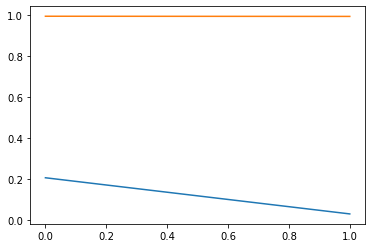

In [38]:
plt.plot(metrics)
plt.show()

In [42]:
# clean this up and turn into a function/routine.
# need to put encoder in deterministic mode...
enc_config = TransformerConfig(
    dtype = jnp.float16, # doesn't seem to be working :(
    vocab_size = 223,
    output_vocab_size = 223, # make this programmatic.
    emb_dim = 256,
    num_heads = 8,
    num_layers = 4,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 24,
    deterministic = True
)


E = Encoder(enc_config)
e_params = {"params": optimized_st_params["params"]["encoder"]}

# TRAIN_X = data, TRAIN_M = attention masks
TRAIN_X_ENC = E.apply(e_params, TRAIN_X[:30_000], encoder_mask=TRAIN_M[30_000])
VAL_X_ENC = E.apply(e_params, VAL_X, encoder_mask=VAL_M)

In [43]:
@jax.jit
def to_fingerprint(embedding_sequences):
    mean_pool = jnp.mean(embedding_sequences, axis=-2)
    max_pool = jnp.mean(embedding_sequences, axis=-2)
    return jnp.concatenate([mean_pool, max_pool], axis=-1)

In [44]:
TRAIN_FPRINTS = to_fingerprint(TRAIN_X_ENC)
VAL_FPRINTS = to_fingerprint(VAL_X_ENC)

In [45]:
class MLP(nn.Module):                    # notsure if this is a good architecture. maybe add skip connections??
    out_dims: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        #x = nn.Dense(512)(x)                 # create inline Flax Module submodules
        #x = nn.relu(x)
        x = nn.Dense(256)(x)                 # create inline Flax Module submodules
        x = nn.gelu(x)
        x = nn.Dense(128)(x)                 # create inline Flax Module submodules
        x = nn.gelu(x)
        x = nn.Dense(self.out_dims)(x)       # shape inference
        return x

QM9_net = MLP(out_dims=12)                 # instantiate the MLP model

sample_batches = shuffler(TRAIN_FPRINTS, 128, pretraining=False)((TRAIN_FPRINTS,TRAIN_Y),
                                                                 jax.random.PRNGKey(0))[0]
QM9_params = QM9_net.init(jax.random.PRNGKey(42), sample_batches[0])

In [46]:
# The ST paper trained for 5 epochs on 860k molecules, so we'll train for 4 epochs on 110k molecules
def train_QM9_predictor(net, net_params, epochs=40, batch_size=128, schedule=2e-4):

    ################################################
    ### Create our optimizer and other utilities ###
    ################################################

    # create optimizer
    opt = optax.lion(learning_rate = schedule)
    # create and initialize the optimizer
    opt_state = opt.init(net_params)
    
    shuffle = shuffler(TRAIN_FPRINTS, batch_size, pretraining=False)
    
    ######################################################################
    ### Define our MLP forward pass/gradient computation               ###
    ######################################################################
    def _net_eval(weights, fingerprints, properties):
        logits = net.apply(weights, fingerprints)
        return jnp.mean(optax.squared_error(logits, properties))
            
    net_eval = jax.value_and_grad(_net_eval)
    
    #########################################################################
    ### Define our train step function that computes grad and updates opt ###
    #########################################################################
    
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state = state
        # unpack data
        fingerprints, properties = data
        # compute loss and gradient
        loss, grads = net_eval(grad_params, fingerprints, properties)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss
    
    
    #####################################################################
    ### Define our val step function that computes validation MAE     ###
    #####################################################################
    
    # For validation epochs, do the same as before but compute the
    # accuracy (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data, targets):
        # apply the network to the data
        logits = net.apply(grad_params, data)
        # compute accuracy, predictions, and loss
        acc = jnp.mean(jnp.abs(targets - logits), axis=0)
        # we return the parameters here because of how jax.scan is structured.
        return acc
    
    
    ##################################################################################
    ### Define our epoch function which will run the training step and compute acc ###
    ##################################################################################
    
    rng = jax.random.PRNGKey(0)
    
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = shuffle((TRAIN_FPRINTS, TRAIN_Y), shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
        )

        new_params, _ = end_state

        # val epoch
        val_metrics = eval_step(new_params, VAL_FPRINTS, VAL_Y)

        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), val_metrics])
    # end epoch

    ##################################################################################
    ### Invoke our training loop by scanning the epoch function over the data!     ###
    ##################################################################################

    final_state, metrics = jax.lax.scan(
        epoch,
        [net_params, opt_state], # metric arrays
        jnp.arange(epochs), #
    )


    final_params, final_optimizer_state = final_state

    # return our final, optimized network.
    return final_params, metrics

In [53]:
optimized_QM9_params, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]

In [55]:
chemical_accuracy = jnp.array([
    0.1,
    0.1,
    0.043,
    0.043,
    0.043,
    1.2,
    .0012,
    .043,
    .043,
    .043,
    .043,
    .050,
])
chemical_accuracy.shape

(12,)

In [56]:
error_ratios = val_acc / chemical_accuracy

In [57]:
print(error_ratios[-1])

[7.5161476e+00 6.4228387e+00 1.7049726e+01 1.6395144e+01 1.5341589e+01
 4.4635013e-01 5.0423999e+02 1.3944131e+01 1.3952463e+01 1.3956611e+01
 1.3944373e+01 1.1495222e+01]


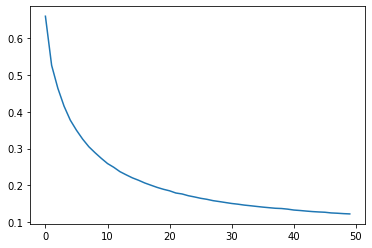

In [58]:
plt.plot(train_loss)
plt.show()

# ECFP4 Embeddings

In [112]:
TRAIN_X[0]

Array([ 66,  31,  55, 184,  72, 114,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=uint8)

In [69]:
def load_as_ecfp4(data_fpath):
    # load data from csv
    smiles, properties = load_data(data_fpath)
    
    # Standardize target values
    targets = jnp.array(properties[["0","1","2","3","4","5","6","12","13","14","15","11"]])
    stan_targets = standardize_array(targets)
    
    mols = smiles.map(Chem.MolFromSmiles)
    mols.dropna(inplace=True)
    ecfp4 = mols.map(lambda mol: Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512))
    
    return jnp.array(ecfp4), stan_targets

In [70]:
ecfp4_fprints, targets = load_as_ecfp4("train.csv")

[11:20:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 7 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 7 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:20:06] Explicit valence for atom # 6 C, 5, is g

[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is g

[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is g

[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is g

[11:20:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is g

[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 6 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:08] Explicit valence for atom # 4 C, 5, is g

[11:20:09] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 8 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:20:09] Explicit valence for atom # 4 C, 5, is greater than permitted


TypeError: Value '[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcdc2a19cb0>
 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcdc2a19d20>
 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcdc2a19d90>
 ...
 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcfc4298ac0>
 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcfc4298b30>
 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fcfc4298ba0>]' with dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [90]:
derp = np.array(ecfp4_fprints.map(lambda m: np.array(m.ToList())))

In [91]:
derp

array([array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]),
       array([0, 0, 0, ..., 0, 0, 0]), ...,
       array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]),
       array([0, 0, 0, ..., 0, 0, 0])], dtype=object)